In [1]:
import jax, tqdm
import jax.numpy as jnp
import numpy as np

from jax import grad, jacobian, hessian
from jax.nn import softmax, log_softmax

from scipy.optimize import minimize

from numpyro.optim import Adam, SGD

from functools import partial

np.random.seed(123)
np.set_printoptions(suppress=True)

/home/jalko/.conda/envs/waltti/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We want to minimize the probability of returning a wrong category under the DP guarantee. We do this by learning utility scores for the exponential mechanism. We also want to minimize the probability of releasing categories that are far from the truth. For the latter, we penalise the loss function with an distance penalty.

## Setting the data

Now replicate the setting described in the [Problem statement](https://github.com/tvv-lippu-ja-maksujarjestelma-oy/waltti-apc-anonymization-plan/blob/main/README.md)

In [2]:
n_seats = 78
n_cats = 6
cat_edges = [5, 40, 50, 65, 72, 78]
print(cat_edges)
categories = np.empty((n_seats+1, n_cats))
j = 0
for i in range(n_seats+1):
    if i > cat_edges[j]:
        j += 1
    categories[i] = np.eye(n_cats)[j]
print(np.sum(categories, axis=0))

[5, 40, 50, 65, 72, 78]
[ 6. 35. 10. 15.  7.  6.]


In [3]:
# compute distance to the edge per category, how many passengers need to add/remove to fall into the bin
category_bins = [[0,5], [6, 40], [41, 50], [51, 65], [66, 72], [73, 78]]
distance_matrix = np.zeros((n_seats+1, n_cats))
current_cat = 0
for i in range(n_seats+1):
    if i > cat_edges[current_cat]:
        current_cat += 1
    for j in range(n_cats):
        if j < current_cat:
            distance_matrix[i, j] = np.abs(i-category_bins[j][1])
        elif j > current_cat:
            distance_matrix[i, j] = np.abs(i-category_bins[j][0])
        else:
            distance_matrix[i, j] = 0

## Training with SGD

In [27]:
from infer import adp_penalty, pure_dp_penalty, l2_penalty, distance_penalty, learn_with_sgd

epsilon_target = 0.1
delta_target = 1e-6

assert epsilon_target > 0 and 0 <= delta_target <= 1, f'Invalid privacy params: eps={epsilon_target}, delta={delta_target}!'

# create a prototype penalties to initialize the task
distance_penalty_fn = partial(distance_penalty, distances=distance_matrix)
if delta_target == 0:
    dp_penalty_fn = partial(pure_dp_penalty, eps=epsilon_target)
else:
    dp_penalty_fn = partial(adp_penalty, eps=epsilon_target, delta_target=delta_target)

def create_penalty_fn(l2_weight, dist_weight, dp_weight):
    def penalty_fn(qs):
        return l2_weight * l2_penalty(qs) + dist_weight * distance_penalty_fn(qs) + dp_weight * dp_penalty_fn(qs)
    return penalty_fn


# create a prototype penalties to initialize the task
# Testing with pure DP
#total_penalty = create_penalty_fn(l2_weight=0.001, dist_weight=0.00001, dp_weight=10000.)
#total_penalty = create_penalty_fn(l2_weight=0.0, dist_weight=0.0, dp_weight=10000.)
#total_penalty = create_penalty_fn(l2_weight=0.0, dist_weight=0.0, dp_weight=100.) # 
#total_penalty = create_penalty_fn(l2_weight=0.0, dist_weight=0.0, dp_weight=10.) # breaks DP guarantee
#total_penalty = create_penalty_fn(l2_weight=0.0, dist_weight=0.0, dp_weight=50.) # best so far, relatively close to the dp_weight=100.

# testing with ADP
#total_penalty = create_penalty_fn(l2_weight=0.0, dist_weight=0.0, dp_weight=100.) # breaks delta with ~2.6e-7
total_penalty = create_penalty_fn(l2_weight=0.0, dist_weight=0.0, dp_weight=1000.)

task = learn_with_sgd(categories, total_penalty)

n_iters = 100000000
learned_logits = task.train(n_iters, init_seed=0, silent=False, optimizer=SGD(1e-6))
    

Loss 46.93: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:32<00:00,  5.72s/it]


### Empirical check for DPness

Now as we have trained the utility scores, we can varify that the learned solution is DP. 
For $\epsilon$-DP, we of course require 
\begin{align}
    | \log \Pr(M(C+1) = i) - \log \Pr(M(C) = i) | \leq \epsilon,
\end{align}
for counts $C$ and $C+1$ produced by neighbouring data sets. We can verify this now simply by comparing the learned log-probabilities between concecutive counts.

In [28]:
final_ps = jax.nn.softmax(learned_logits.reshape((n_seats+1, -1)))
logps = np.log(final_ps)
if delta_target == 0:
    max_abs_logdiff_for_count = np.max(np.array([np.abs(logps[i] - logps[i+1]) for i in range(0, n_seats)]), axis=1)
    print(max_abs_logdiff_for_count)
    print(max_abs_logdiff_for_count.max())
    print(np.max(max_abs_logdiff_for_count) < epsilon_target)

In [29]:
if delta_target > 0:
    print(dp_penalty_fn(learned_logits) / delta_target)
    print(dp_penalty_fn(learned_logits))

2807.444
0.0028074442


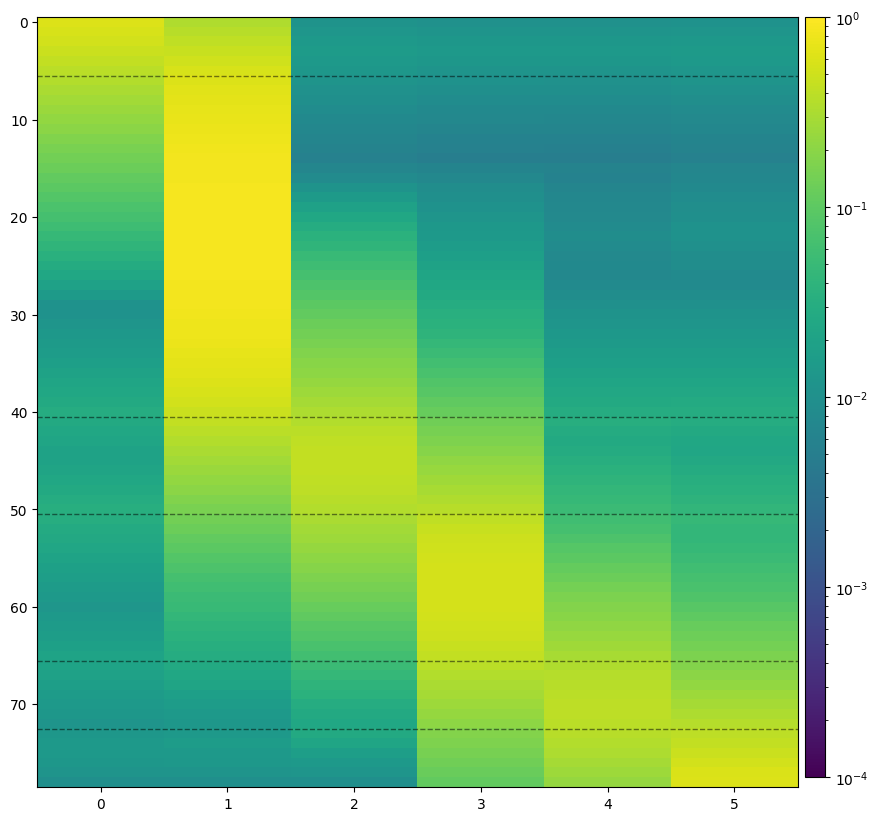

In [30]:
import matplotlib.pyplot as plt

fig, axis = plt.subplots(figsize=(10,10))

im = axis.imshow(final_ps, aspect=n_cats / n_seats, vmin=1e-4, vmax=1., norm='log')
for edge in cat_edges[:-1]:
    axis.axhline(edge+0.5, color='k', lw=1, ls="--", alpha=0.5)
cbar_ax = fig.add_axes([0.9, 0.12, 0.02, 0.76])
fig.colorbar(im, cax=cbar_ax)

plt.show()

## Comparing against Laplace mechanism

In [71]:
from scipy.stats import laplace, norm

def analytical_gaussian(epsilon, sigma):
    term1 = norm.cdf(1./(2.*sigma) - epsilon*sigma)
    term2 = np.exp(epsilon) * norm.cdf(-1./(2.*sigma) - epsilon*sigma)
    return term1 - term2

In [72]:
cat_bins = np.array([[-np.inf, 5], [6, 40], [41, 50], [51, 65], [66, 72], [73, np.inf]])
    
def table_from_laplace(epsilon):
    probs = np.zeros((n_seats+1, n_cats))
    for i in range(n_seats+1):
        true_cat = np.where(categories[i])[0][0]
        for j in range(n_cats):
            cat_left_edge, cat_right_edge = cat_bins[j]
            probs[i, j] = laplace.cdf(cat_right_edge+0.5-i, scale=epsilon) - laplace.cdf(cat_left_edge-0.5-i, scale=epsilon)    
    return probs

def table_from_gaussian(epsilon, delta):
    from scipy.optimize import fsolve
    gaussian_sigma = fsolve(lambda x: np.abs(analytical_gaussian(epsilon, x) - delta), x0=1.)

    probs = np.zeros((n_seats+1, n_cats))
    for i in range(n_seats+1):
        true_cat = np.where(categories[i])[0][0]
        for j in range(n_cats):
            cat_left_edge, cat_right_edge = cat_bins[j]            
            probs[i, j] = norm.cdf(cat_right_edge+0.5-i, scale=gaussian_sigma) - norm.cdf(cat_left_edge-0.5-i, scale=gaussian_sigma)
    return probs

if delta_target > 0.:
    comparison_table = table_from_gaussian(epsilon_target, delta_target)
else:
    comparison_table = table_from_laplace(epsilon_target)

In [73]:
(comparison_table * categories).sum() / (n_seats + 1)

0.8410992087241451

In [74]:
(final_ps * categories).sum() / (n_seats + 1)

DeviceArray(0.94556594, dtype=float32)

In [75]:
final_ps[78]

DeviceArray([0.        , 0.        , 0.        , 0.00000165, 0.00191615,
             0.99808216], dtype=float32)

In [76]:
comparison_table[78]

array([0.        , 0.        , 0.        , 0.00004359, 0.04208844,
       0.95786797])

In [78]:
gaussian_sigma = fsolve(lambda x: np.abs(analytical_gaussian(epsilon_target, x) - delta_target), x0=1.)

In [79]:
gaussian_sigma

array([3.18570299])

In [80]:
norm.cdf(-0.5, scale=gaussian_sigma)

array([0.43764164])

In [82]:
laplace.cdf(-0.5, scale=epsilon_target)

0.3032653298563167

In [84]:
np.sqrt(2 * np.log(1.25/delta_target)) / epsilon_target

4.34361230389877